# The Pythagorean three body problem

<ul id="top">
<li><a href="#Loading-packages-and-functions"> 
             Loading packages and functions</a></li>
    
<li><a href="#Definition-of-the-problem"> 
             Definition of the problem</a></li>  

<li><a href="#Choose-steps-sizes">
             Choose steps sizes</a></li>

<li><a href="#Compute-exact-solution">
             Compute exact solution</a></li>
             
<li><a href="#Float64-integrations">
              Float64 integrations</a></li>

</ul>  

## Loading packages and functions

In [1]:
using LinearAlgebra
using Plots
using JLD2, Dates, LaTeXStrings
using OrdinaryDiffEq
using BenchmarkTools

In [4]:
#import Pkg; Pkg.add("SIMD")

In [3]:
PATH_SRC="../../src_seq/"
PATH_DATA="./Data/"

include(string(PATH_SRC,"IRKGL_SEQ.jl"))
using .IRKGL_SEQ 


PATH_SRC="../../src_simd/"

include(string(PATH_SRC,"IRKGL_SIMD.jl"))
using .IRKGL_SIMD 

In [5]:
struct mysolution
   sol::ODESolution
   iters::Vector{Float64}
   steps::Float64
end


function coord_bar(out,u)
    
     @. out[:,1,1]=u[:,3,1]-u[:,1,1]
     @. out[:,2,1]=u[:,1,1]-u[:,2,1]
     @. out[:,3,1]=u[:,2,1]-u[:,3,1]
     
     return copy(out)
 
 end

coord_bar (generic function with 1 method)

In [6]:
run=false

false

 <a href="#top">Back to the top</a>
 
 ## Definition of the problem

In [7]:
PATH_ODES="../../ODEProblems/"

include(string(PATH_ODES,"InitialPythagorean3BPREL.jl"))
include(string(PATH_ODES,"Nbody3REL.jl"))

NbodyODE3REL! (generic function with 2 methods)

### Initial value problem: Pythagorean 3 body problem

In [8]:
u0, Gm, bodylist = InitialPythagorean3BPREL(Float64)
dim=length(size(u0))
N = length(Gm)

t0=0.
tf=63.
prob = ODEProblem(NbodyODE3REL!, u0, (t0,tf), Gm)

setprecision(BigFloat, 108);
u0B, GmB, bodylist = InitialPythagorean3BPREL(BigFloat)
tspanB=(BigFloat(t0),BigFloat(tf))
probB = ODEProblem(NbodyODE3REL!,u0B,tspanB,GmB);

In [11]:
dt=0.6

alg=IRKNGL_simd(s=8, initial_interp=1, dim=dim, myoutputs=true)
sol,iters,steps=solve(prob,alg,dt=dt, adaptive=true)
@btime sol,iters,steps=solve(prob,alg,dt=dt, adaptive=true)

steps

  5.566 ms (47353 allocations: 5.42 MiB)


1476

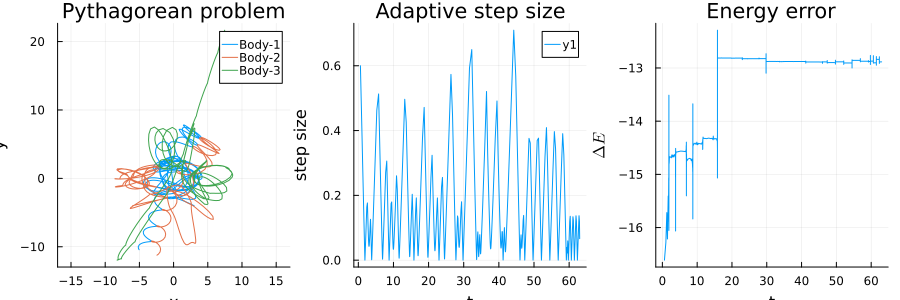

In [12]:
bodylist = ["Body-1", "Body-2", "Body-3"]
pl = plot(title="Pythagorean problem",xlabel="x", ylabel="y",aspect_ratio=1)

out=similar(u0)
ulist =[coord_bar(out,u) for u in sol.u]
tlist = sol.t[1:end]

for j = 1:3
 xlist  = map(u->u[1,j,1], ulist)
 ylist  = map(u->u[2,j,1], ulist)
 pl = plot!(xlist,ylist, label = bodylist[j])   
end  

pl2=plot(xlabel="t", ylabel="step size",title="Adaptive step size")
steps =sol.t[2:end]-sol.t[1:end-1]
pl2=plot!(sol.t[2:end],steps)

setprecision(BigFloat, 256)
u0Big=BigFloat.(u0)
GmBig=BigFloat.(Gm)

E0=NbodyEnergy3REL(u0Big,GmBig)
ΔE1 = map(x->NbodyEnergy3REL(BigFloat.(x),GmBig), sol.u)./E0.-1
pl3=plot(title="Energy error", xlabel="t", ylabel=L"\Delta E")
pl3=plot!(sol.t,log10.(abs.(ΔE1)), label="")

plot(pl,pl2,pl3, layout=(1,3), size=(900,300))

In [15]:
sol_Vern9=solve(prob,Vern9(), abstol=1e-10, reltol=1e-10, adaptive=true)
@btime sol_Vern9=solve(prob,Vern9(), abstol=1e-10, reltol=1e-10, adaptive=true)
length(sol_Vern9.t)


  4.358 ms (31170 allocations: 4.83 MiB)


2593

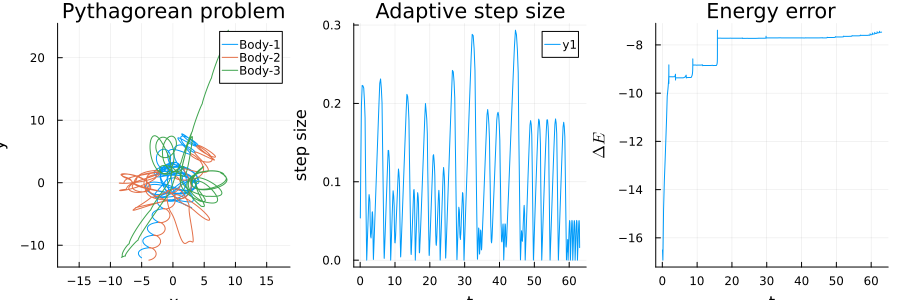

In [16]:
bodylist = ["Body-1", "Body-2", "Body-3"]
pl = plot(title="Pythagorean problem",xlabel="x", ylabel="y",aspect_ratio=1)

out=similar(u0)
ulist =[coord_bar(out,u) for u in sol_Vern9.u]
tlist = sol_Vern9.t[1:end]

for j = 1:3
 xlist  = map(u->u[1,j,1], ulist)
 ylist  = map(u->u[2,j,1], ulist)
 pl = plot!(xlist,ylist, label = bodylist[j])   
end  

pl2=plot(xlabel="t", ylabel="step size",title="Adaptive step size")
steps =sol_Vern9.t[2:end]-sol_Vern9.t[1:end-1]
pl2=plot!(sol_Vern9.t[2:end],steps)

setprecision(BigFloat, 256)
u0Big=BigFloat.(u0)
GmBig=BigFloat.(Gm)

E0=NbodyEnergy3REL(u0Big,GmBig)
ΔE1 = map(x->NbodyEnergy3REL(BigFloat.(x),GmBig), sol_Vern9.u)./E0.-1
pl3=plot(title="Energy error", xlabel="t", ylabel=L"\Delta E")
pl3=plot!(sol_Vern9.t,log10.(abs.(ΔE1)), label="")

plot(pl,pl2,pl3, layout=(1,3), size=(900,300))

<a href="#top">Back to the top</a>

## Choose steps sizes

### Truncation error below round-off

In [17]:
dtB=BigFloat(0.6)

alg=IRKNGL_Seq(s=8, initial_interp=1, myoutputs=true)
sol,iter,steps=solve(probB,alg, dt=dtB,  adaptive=true)

[sol.retcode steps]

1×2 Matrix{Any}:
 ReturnCode.Success = 1  1476

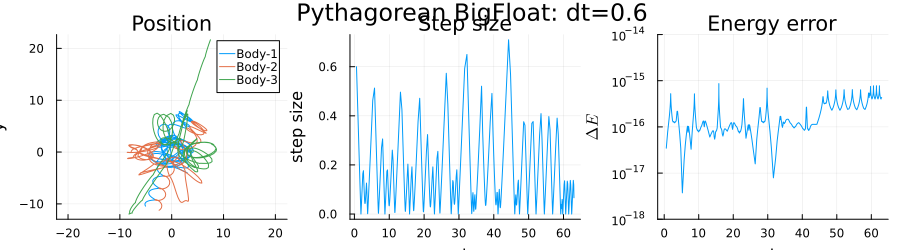

┌ Warning: Invalid negative or zero value 0.0 found at series index 1 for log10 based yscale
└ @ Plots ~/.julia/packages/Plots/sxUvK/src/utils.jl:106
┌ Warning: Invalid negative or zero value 0.0 found at series index 1 for log10 based yscale
└ @ Plots ~/.julia/packages/Plots/sxUvK/src/utils.jl:106
┌ Warning: Invalid negative or zero value 0.0 found at series index 1 for log10 based yscale
└ @ Plots ~/.julia/packages/Plots/sxUvK/src/utils.jl:106


In [18]:
bodylist = ["Body-1", "Body-2", "Body-3"]
pl = plot(title="Position",xlabel="x", ylabel="y",aspect_ratio=1)

out=similar(u0)
uu =[coord_bar(out,u) for u in sol.u]
tt=sol.t[1:end]

for j = 1:3
    xlist  = map(u->u[1,j,1], uu)
    ylist  = map(u->u[2,j,1], uu)
 pl = plot!(xlist,ylist, label = bodylist[j])   
end  

pl2=plot(xlabel="t", ylabel="step size",title="Step size")
steps =sol.t[2:end]-sol.t[1:end-1]
pl2=plot!(sol.t[2:end],steps,label="")

setprecision(BigFloat, 256)
u0Big=BigFloat.(u0)
GmBig=BigFloat.(Gm)

yrange = (1e-18,1e-14)
E0=NbodyEnergy3REL(u0Big,GmBig)
ΔE1 = map(x->NbodyEnergy3REL(BigFloat.(x),GmBig), sol.u)./E0.-1
pl3=plot(title="Energy error", xlabel="t", ylabel=L"\Delta E")
pl3=plot!(tt,abs.(ΔE1), yscale=:log10, ylimits=yrange, label="")

plot(pl,pl2, pl3, layout=(1,3), size=(900,250), plot_title="Pythagorean BigFloat: dt=0.6")

### Truncation error above round-off

In [19]:
dtB=BigFloat(0.65)

alg=IRKNGL_Seq(s=8, initial_interp=1, myoutputs=true)
sol,iter,steps=solve(probB,alg, dt=dtB,   adaptive=true)

[sol.retcode steps]

1×2 Matrix{Any}:
 ReturnCode.Success = 1  1340

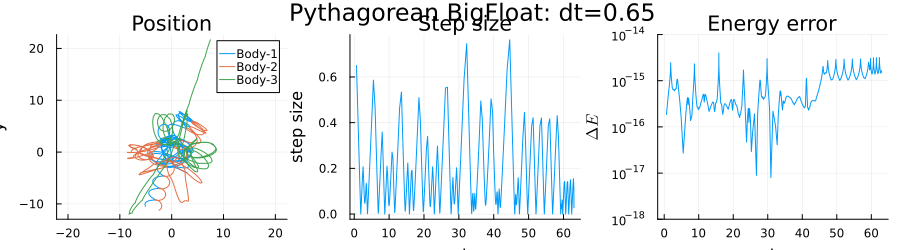

┌ Warning: Invalid negative or zero value 0.0 found at series index 1 for log10 based yscale
└ @ Plots ~/.julia/packages/Plots/sxUvK/src/utils.jl:106
┌ Warning: Invalid negative or zero value 0.0 found at series index 1 for log10 based yscale
└ @ Plots ~/.julia/packages/Plots/sxUvK/src/utils.jl:106
┌ Warning: Invalid negative or zero value 0.0 found at series index 1 for log10 based yscale
└ @ Plots ~/.julia/packages/Plots/sxUvK/src/utils.jl:106


In [20]:
bodylist = ["Body-1", "Body-2", "Body-3"]
pl = plot(title="Position",xlabel="x", ylabel="y",aspect_ratio=1)

uu =[coord_bar(out,u) for u in sol.u]
tt=sol.t[1:end]

for j = 1:3
    xlist  = map(u->u[1,j,1], uu)
    ylist  = map(u->u[2,j,1], uu)
 pl = plot!(xlist,ylist, label = bodylist[j])   
end  

pl2=plot(xlabel="t", ylabel="step size",title="Step size")
steps =sol.t[2:end]-sol.t[1:end-1]
pl2=plot!(sol.t[2:end],steps, label="")

setprecision(BigFloat, 256)
u0Big=BigFloat.(u0)
GmBig=BigFloat.(Gm)

yrange = (1e-18,1e-14)
E0=NbodyEnergy3REL(u0Big,GmBig)
ΔE1 = map(x->NbodyEnergy3REL(BigFloat.(x),GmBig), sol.u)./E0.-1
pl3=plot(title="Energy error", xlabel="t", ylabel=L"\Delta E")
pl3=plot!(tt,abs.(ΔE1), yscale=:log10, ylimits=yrange, label="")

plot(pl,pl2, pl3, layout=(1,3), size=(900,250), plot_title="Pythagorean BigFloat: dt=0.65")

<a href="#top">Back to the top</a>

## Compute exact solution

In [ ]:
dtB=BigFloat(0.05)
saveatB=BigFloat(0.05)

if run==true
   alg=IRKNGL_Seq(s=8, initial_interp=1, myoutputs=true)
   sol0,iters0,steps0=solve(probB,alg, dt=dtB, saveat=saveatB, adaptive=true)
   s=mysolution(sol0,iters0,steps0)
   @save string(PATH_DATA,"sol0.jld2") s
else
   JLD2.@load string(PATH_DATA,"sol0.jld2") s
   sol0=s.sol
   iters0=s.iters
   steps0=s.steps
end

[sol0.retcode steps0]

In [ ]:
bodylist = ["Body-1", "Body-2", "Body-3"]
pl = plot(title="Position", xlabel="x", ylabel="y",aspect_ratio=1)

uu =[coord_bar(out,u) for u in sol0.u]
tt=sol0.t[1:end]

for j = 1:3
    xlist  = map(u->u[1,j,1], uu)
    ylist  = map(u->u[2,j,1], uu)
    pl = plot!(xlist,ylist, label = bodylist[j])   
end  

setprecision(BigFloat, 256)
u0Big=BigFloat.(u0)
GmBig=BigFloat.(Gm)


E0=NbodyEnergy3REL(u0Big,GmBig)
ΔE1 = map(x->NbodyEnergy3REL(BigFloat.(x),GmBig), sol0.u)./E0.-1
pl3=plot(title="Energy error", xlabel="t", ylabel=L"\Delta E")
pl3=plot!(tt,abs.(ΔE1), yscale=:log10, label="")

plot(pl,pl3, layout=(1,2), size=(900,300), plot_title="Pythagorean problem: exact solution")

<a href="#top">Back to the top</a>

## Float64 integrations

### Truncation error below round-off

In [ ]:
dt=0.6
saveat=0.6

alg=IRKNGL_simd(s=8, initial_interp=1, myoutputs=true)
sol11,iters11,steps11=solve(prob,alg,dt=dt, saveat=saveat, adaptive=true)

[sol11.retcode steps11]

#### Some Checks

In [ ]:
index=1:12:length(sol0.t)
ssol0=sol0[index]
sols=[ssol0, sol11]
for sol in sols
    println("length=",length(sol.t))
end

In [ ]:
k=20
for sol in sols
    println("norm=", norm(ssol0.u[1]-sol.u[1]), 
            ", sol.t[1]=",Float32(sol.t[1]), ", sol.t[k]=",Float32(sol.t[k]), ", sol.t[end]=", sol.t[end])
end

#### Graphics

In [ ]:
bodylist = ["Body-1", "Body-2", "Body-3"]
pl11 = plot(title="Position",xlabel="x", ylabel="y",aspect_ratio=1)

uu =[coord_bar(out,u) for u in sol11.u]
tt=sol11.t[1:end]

for j = 1:3
    xlist  = map(u->u[1,j,1], uu)
    ylist  = map(u->u[2,j,1], uu)
    pl11 = plot!(xlist,ylist, label_="" ) #label = bodylist[j])   
end  

In [ ]:
setprecision(BigFloat, 256)
u0Big=BigFloat.(u0)
GmBig=BigFloat.(Gm)

yrange = (1e-18,1e-8)
E0=NbodyEnergy3REL(u0Big,GmBig)
ΔE1 = map(x->NbodyEnergy3REL(BigFloat.(x),GmBig), sol11.u)./E0.-1
pl12=plot(title="Energy error", xlabel="t", ylabel=L"\Delta E")
pl12=plot!(tt,abs.(ΔE1), yscale=:log10, ylimits=yrange, label="");

In [ ]:
qe11=Array{Array{Float64,1}}(undef,N)
for i in 1:N
    qe11[i]=map((u0,u11)-> abs(norm(u11[:,i,2])/norm(u0[:,i,2])-1), ssol0.u[2:end],sol11.u[2:end])
end

yrange=(1e-20,-1)

pl13=plot(sol11.t[2:end], qe11, title="Error in position",
     ylims=yrange, xlabel="t", ylabel=error, 
     yscale=:log10, legend=false);

In [ ]:
plot(pl11,pl12,pl13, layout=(1,3), size=(900,250), plot_title="IRKNGL_simd Float64: dt=0.6")

### Truncation error above round-off

In [ ]:
dt=0.65
saveat=0.65

alg=IRKNGL_simd(s=8, initial_interp=1, myoutputs=true)
sol12,iters12,steps12=solve(prob,alg,dt=dt, saveat=saveat, adaptive=true)

[sol12.retcode steps12]

#### Some Checks

In [ ]:
index=1:13:length(sol0.t)-1
ssol0=sol0[index]
sols=[ssol0, sol12[1:end-1]]
for sol in sols
println("length=",length(sol.t))
end

In [ ]:
k=4
for sol in sols
println("norm=", norm(ssol0.u[1]-sol.u[1]),
", sol.t[1]=",Float32(sol.t[1]), ", sol.t[k]=",Float32(sol.t[k]),
 ", sol.t[end]=", sol.t[end])
end

#### Graphics

In [ ]:
bodylist = ["Body-1", "Body-2", "Body-3"]
pl21 = plot(title="Position",xlabel="x", ylabel="y",aspect_ratio=1)

uu =[coord_bar(out,u) for u in sol12.u]
tt=sol12.t[1:end]

for j = 1:3
  xlist = map(u->u[1,j,1], uu)
  ylist = map(u->u[2,j,1], uu)
  pl21 = plot!(xlist,ylist, label_="" ) #label = bodylist[j])
end

In [ ]:
setprecision(BigFloat, 256)
u0Big=BigFloat.(u0)
GmBig=BigFloat.(Gm)

yrange = (1e-18,1e-8)
E0=NbodyEnergy3REL(u0Big,GmBig)
ΔE1 = map(x->NbodyEnergy3REL(BigFloat.(x),GmBig), sol12.u)./E0.-1
pl22=plot(title="Energy error", xlabel="t", ylabel=L"\Delta E")
pl22=plot!(tt,abs.(ΔE1), yscale=:log10, ylimits=yrange, label="");

In [ ]:
qe12=Array{Array{Float64,1}}(undef,N)
for i in 1:N
   qe12[i]=map((u0,u12)-> abs(norm(u12[:,i,2])/norm(u0[:,i,2])-1), ssol0.u[2:end],sol12.u[2:end])
end
yrange=(1e-20,-1)
pl23=plot(sol12.t[2:end-1], qe12, title="Error in position",
         ylims=yrange, xlabel="t", ylabel=error,
         yscale=:log10, legend=false);

In [ ]:
plot(pl21,pl22,pl23, layout=(1,3), size=(900,250), plot_title="IRKNGL_simd Float64: dt=0.65")

In [ ]:
plot(pl11,pl12,pl13, layout=(1,3), size=(900,250), plot_title="IRKNGL_simd Float64: dt=0.6")